In [1]:
# !pip install -U matplotlib --quiet
# !pip install torch --quiet
# !pip install lightning --quiet

In [2]:
# !git clone https://github.com/QMCSoftware/QMCSoftware
# !cd QMCSoftware && git checkout qmctoolscl_integration
# !cd QMCSoftware && git pull
# !cd QMCSoftware && pip install -e .

# CHONKNORIS for a 1 dimensional Burgers equation

Here we will solve the PDE

$$\begin{cases} \partial_t v + v \partial_x v - \nu \partial_x^2 v = 0, & (x,t) \in (0,1) \times (0,1] \\ v(x,0) = u(x), & x \in (0,1) \\ v(0,t) = v(1,t) = 0, & t \in [0,1]\end{cases}$$

In [3]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # cholesky not implemented on MPS, fall back to CPU
import torch

In [4]:
# may need to Runtime > Restart session if loading for the first time on Google Colab
import torch
import qmcpy as qp
import pandas as pd
import numpy as np
import lightning
import gpytorch
import time
from collections import OrderedDict
import os
import glob
import warnings
from typing import List

In [5]:
ROOT = "."
assert os.path.isfile(ROOT+"/burgers_1d.ipynb")

In [6]:
assert torch.cuda.is_available() or torch.backends.mps.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "mps"
DEVICE

'cuda'

In [7]:
from matplotlib import pyplot,cm,colors,gridspec
#print(pyplot.style.available)
pyplot.style.use('seaborn-v0_8-whitegrid') 
LW = 3 # linewidth
LWTHIN = 0.01
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()]

## Reference Solution

Using the [Cole-Hopf transform](https://www.iist.ac.in/sites/default/files/people/IN08026/Burgers_equation_viscous.pdf) we have that 
$$v(x,t) = \frac{\int_{-\infty}^\infty f(\eta) \frac{x-\eta}{t} \exp\left(-\frac{(x-\eta)^2}{4 \nu t}\right) \mathrm{d} \eta}{\int_{-\infty}^\infty f(\eta) \exp\left(-\frac{(x-\eta)^2}{4 \nu t}\right) \mathrm{d} \eta}$$
where $f(x) = \exp\left(-\frac{1}{2\nu} \int_0^x u(y) \mathrm{d} y\right)$. 

We will randomly generate
$$u(x)  = \sum_{k=1}^P a_k \sin (k \pi x)$$
where $a_1,\dots,a_P \overset{\mathrm{IID}}{\sim} \mathcal{N}(0,1)$.
This gives
$$f(x) = \exp\left(-\sum_{k=1}^P \frac{a_k}{2 \nu \pi k} [\cos(\pi k)-\cos(\pi k x)]\right)$$

We use [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature) to numerically approximate the two integrals. To do so, we make the change of variables $z = (x-\eta)/\sqrt{4 \nu t}$ we have $\eta=x-\sqrt{4 \nu t}z$ and $\partial \eta/\partial z = -\sqrt{4 \nu t}$ so 
$$v(x,t) = \sqrt{4 \nu} \frac{\int_{-\infty}^\infty f(x-\sqrt{4 \nu t}z) \frac{z}{\sqrt{t}} \exp\left(-z^2\right) \mathrm{d} z}{\int_{-\infty}^\infty f(x-\sqrt{4 \nu t}z) \exp\left(-z^2\right) \mathrm{d} z}$$


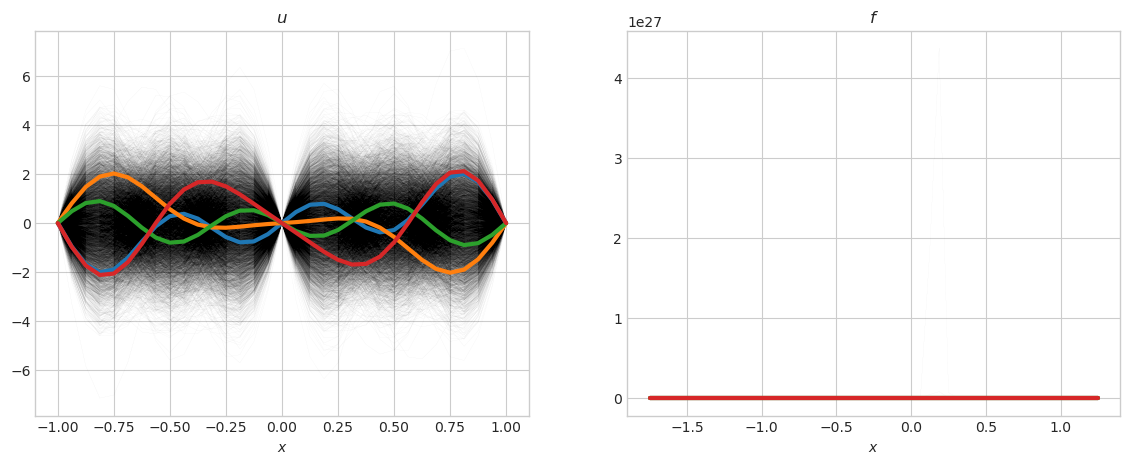

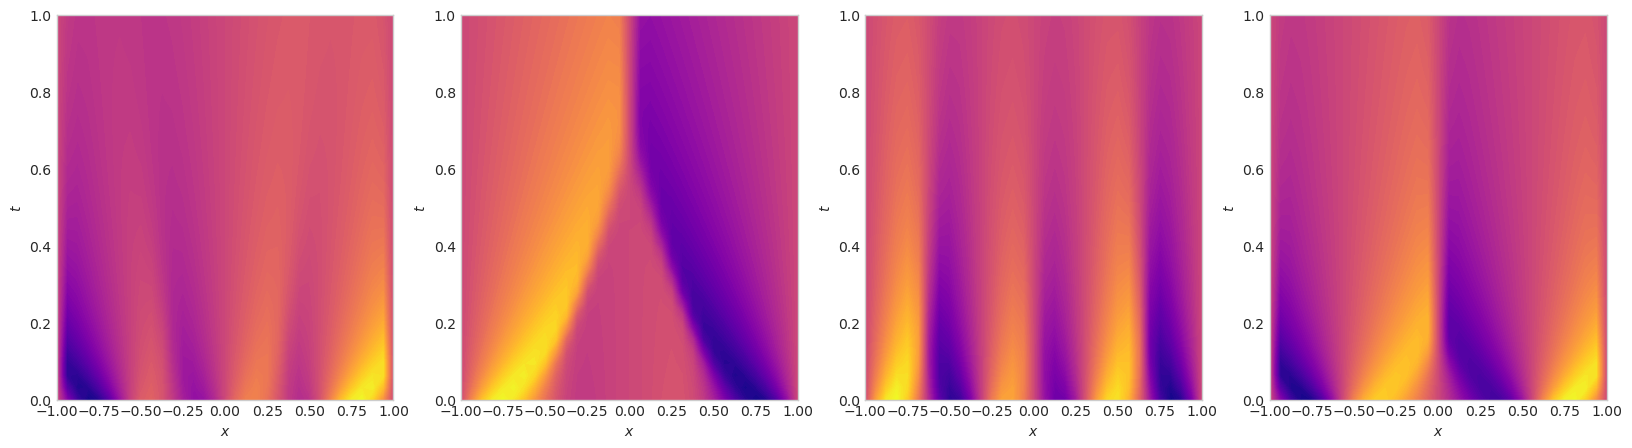

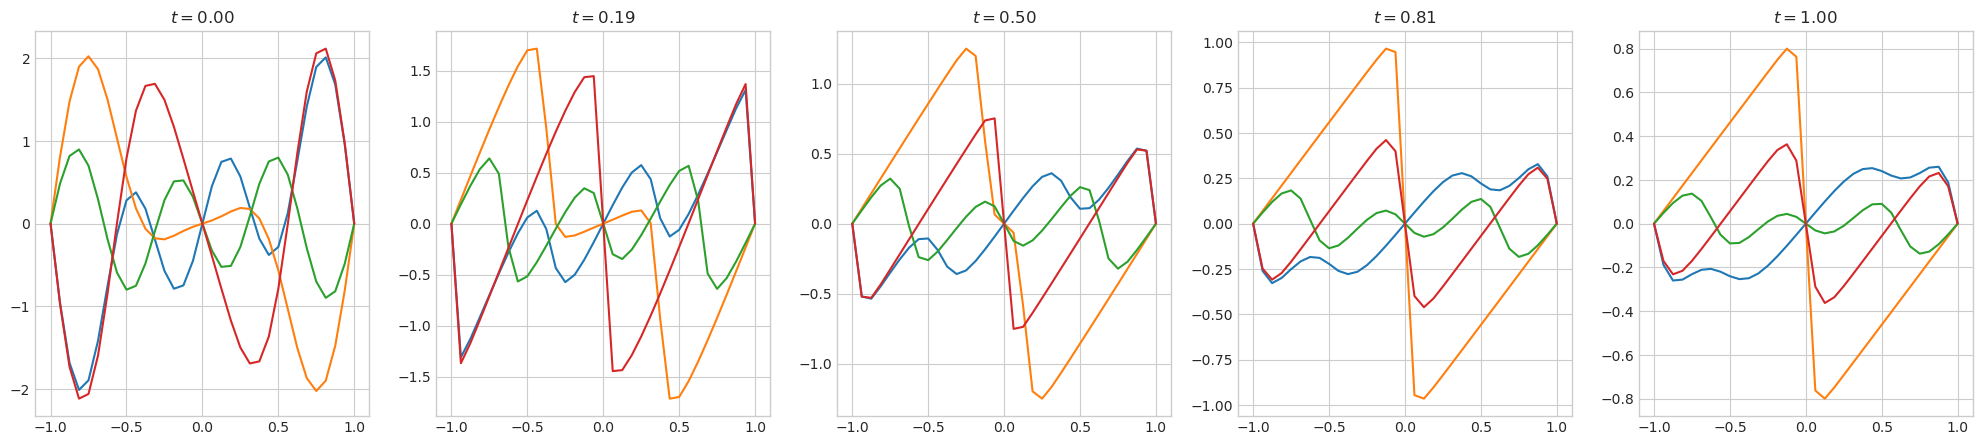

In [8]:
NU = 0.02
P = 3
R = 2**13
GHDEG = 350
nxticks = 33
ntticks = 33
nticks = nxticks*ntticks
xticks = torch.linspace(-1,1,nxticks,device="cpu",dtype=torch.float64)
tticks = torch.linspace(0,1,ntticks,device="cpu",dtype=torch.float64)
xmesh,tmesh = torch.meshgrid(xticks,tticks,indexing="ij")
ticks = torch.vstack([xmesh.flatten(),tmesh.flatten()]).T
a = torch.from_numpy(qp.Gaussian(qp.DigitalNetB2(P,seed=7)).gen_samples(R)).to("cpu")
k = torch.arange(1,P+1,device="cpu")
def u_func(x):
    y = a[:,:,None]*torch.sin(torch.pi*k[:,None]*x)
    return y.sum(1)
u = u_func(xticks) 
def f_func(x):
    y = -1/(2*NU*torch.pi*k[:,None])*a[:,:,None]*(torch.cos(torch.pi*k[:,None])-torch.cos(k[:,None]*torch.pi*x))
    return torch.exp(y.sum(1))
gh_pts,gh_weights = np.polynomial.hermite.hermgauss(GHDEG) 
gh_pts,gh_weights = torch.from_numpy(gh_pts).to("cpu"),torch.from_numpy(gh_weights).to("cpu")
etamesh = xmesh[:,:,None]-torch.sqrt(4*NU*tmesh[:,:,None])*gh_pts
fmesh = f_func(etamesh.flatten()).reshape((-1,*etamesh.shape))
denom = (fmesh*gh_weights).sum(-1)
numer = (fmesh*gh_pts/torch.sqrt(tmesh[:,:,None])*gh_weights).sum(-1)
vticks = np.sqrt(4*NU)*numer/denom
vticks[:,:,0] = u
plt_highlights = 4
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].set_title(r"$u$")
ax[0].set_xlabel(r"$x$")
ax[0].plot(xticks,u.T,linewidth=LWTHIN,color="k")
ax[0].plot(xticks,u[:plt_highlights].T,linewidth=LW)
xticks_ext = xticks*1.5-.25
f = f_func(xticks_ext)
ax[1].set_title(r"$f$")
ax[1].set_xlabel(r"$x$")
ax[1].plot(xticks,f.T,linewidth=LWTHIN,color="k")
ax[1].plot(xticks_ext,f[:plt_highlights].T,linewidth=LW);
#ax[1].set_ylim([0,5])
fig.show()
fig,ax = pyplot.subplots(nrows=1,ncols=plt_highlights,figsize=(5*plt_highlights,5))
for i in range(plt_highlights):
    ax[i].contourf(xmesh,tmesh,vticks[i],cmap=cm.plasma,levels=100)
    ax[i].set_xlabel(r"$x$"); ax[i].set_ylabel(r"$t$")
fig.show()
tpltidxs = [0,ntticks//5,ntticks//2,4*ntticks//5,ntticks-1]
fig,ax = pyplot.subplots(nrows=1,ncols=len(tpltidxs),figsize=(5*len(tpltidxs),5))
for i,tiplt in enumerate(tpltidxs):
    ax[i].set_title(r"$t = %.2f$"%tticks[tiplt])
    ax[i].plot(xticks,vticks[:plt_highlights,:,tiplt].T)

## GP for PDE Solves

$$\begin{cases} \partial_t v + v \partial_x v - \nu \partial_x^2 v = 0, & (x,t) \in (0,1) \times (0,1] \\ v(x,0) = u(x), & x \in (0,1) \\ v(0,t) = v(1,t) = 0, & t \in [0,1]\end{cases}$$

In [9]:
llbetas = [ # derivative orders
    [ # interior
        torch.tensor([[0,0]],dtype=int), # v
        torch.tensor([[1,0]],dtype=int), # v_x
        torch.tensor([[0,1],[2,0]],dtype=int), # v_t - \nu v_xx
    ],
    [ # boundary condition
        torch.tensor([[0,0]],dtype=int) # v
    ],
    [ # initial condition
        torch.tensor([[0,0]],dtype=int) # v 
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # v
        torch.ones(1,dtype=float), # laplacian v
        torch.tensor([1,-NU],dtype=float) # laplacian v
    ],
    [ # boundary condition
        torch.ones(1,dtype=float) # v
    ], 
    [ # initial condition
        torch.ones(1,dtype=float) # v 
    ]
]

ki matrix is 8704 x 8704


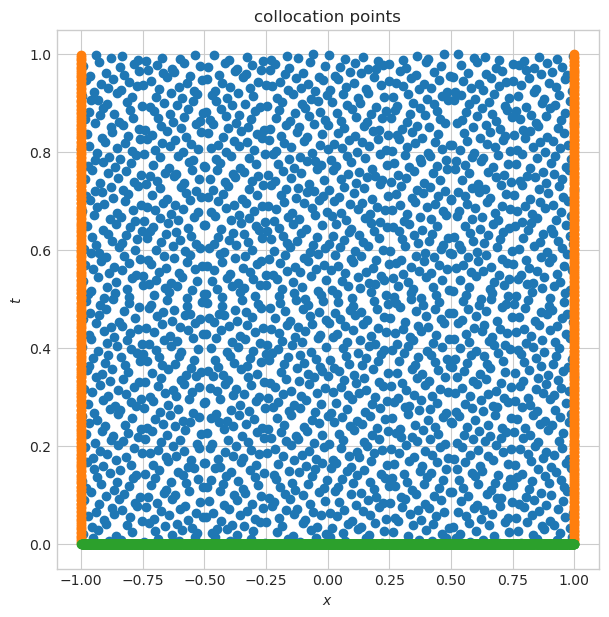

In [10]:
n = 2**11
noise = 1e-10
sampler = qp.Uniform(qp.DigitalNetB2(dimension=2,seed=11),lower_bound=[-1,0],upper_bound=[1,1]) # collocation points
x_i = torch.from_numpy(sampler.gen_samples(n))
x_bc = x_i[:len(x_i)//4].clone(); x_bc[:len(x_bc)//2,0] = -1; x_bc[len(x_bc)//2:,0] = 1 
x_ic = x_i[:len(x_i)].clone(); x_ic[:,1] = 0
xs = [x_i,x_bc,x_ic]
#kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
kernel = qp.KernelGaussian(dimension=2,scale=1.,torchify=True,lengthscales=torch.tensor([1/200,1/100]))#[1e-1,2e0]))#[1/200,1/100]))#[1/20**2,1/3**2]))
ki = qp.PDEGramMatrix(kernel,xs,None,None,llbetas,llcs,noise) # kernel interpolant
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.scatter(x_i[:,0],x_i[:,1])
ax.scatter(x_bc[:,0],x_bc[:,1])
ax.scatter(x_ic[:,0],x_ic[:,1])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$t$")
ax.set_title("collocation points")
print("ki matrix is %d x %d"%(ki.length,ki.length))

iter avg l2rerrs: [1.         0.75850532 0.30536794 0.13924377 0.11440648 0.10951811
 0.10657704]


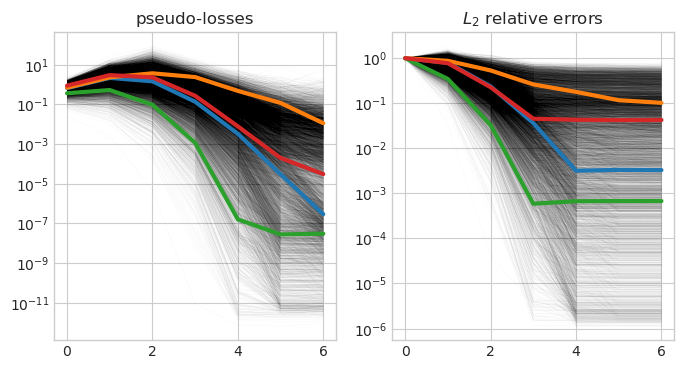

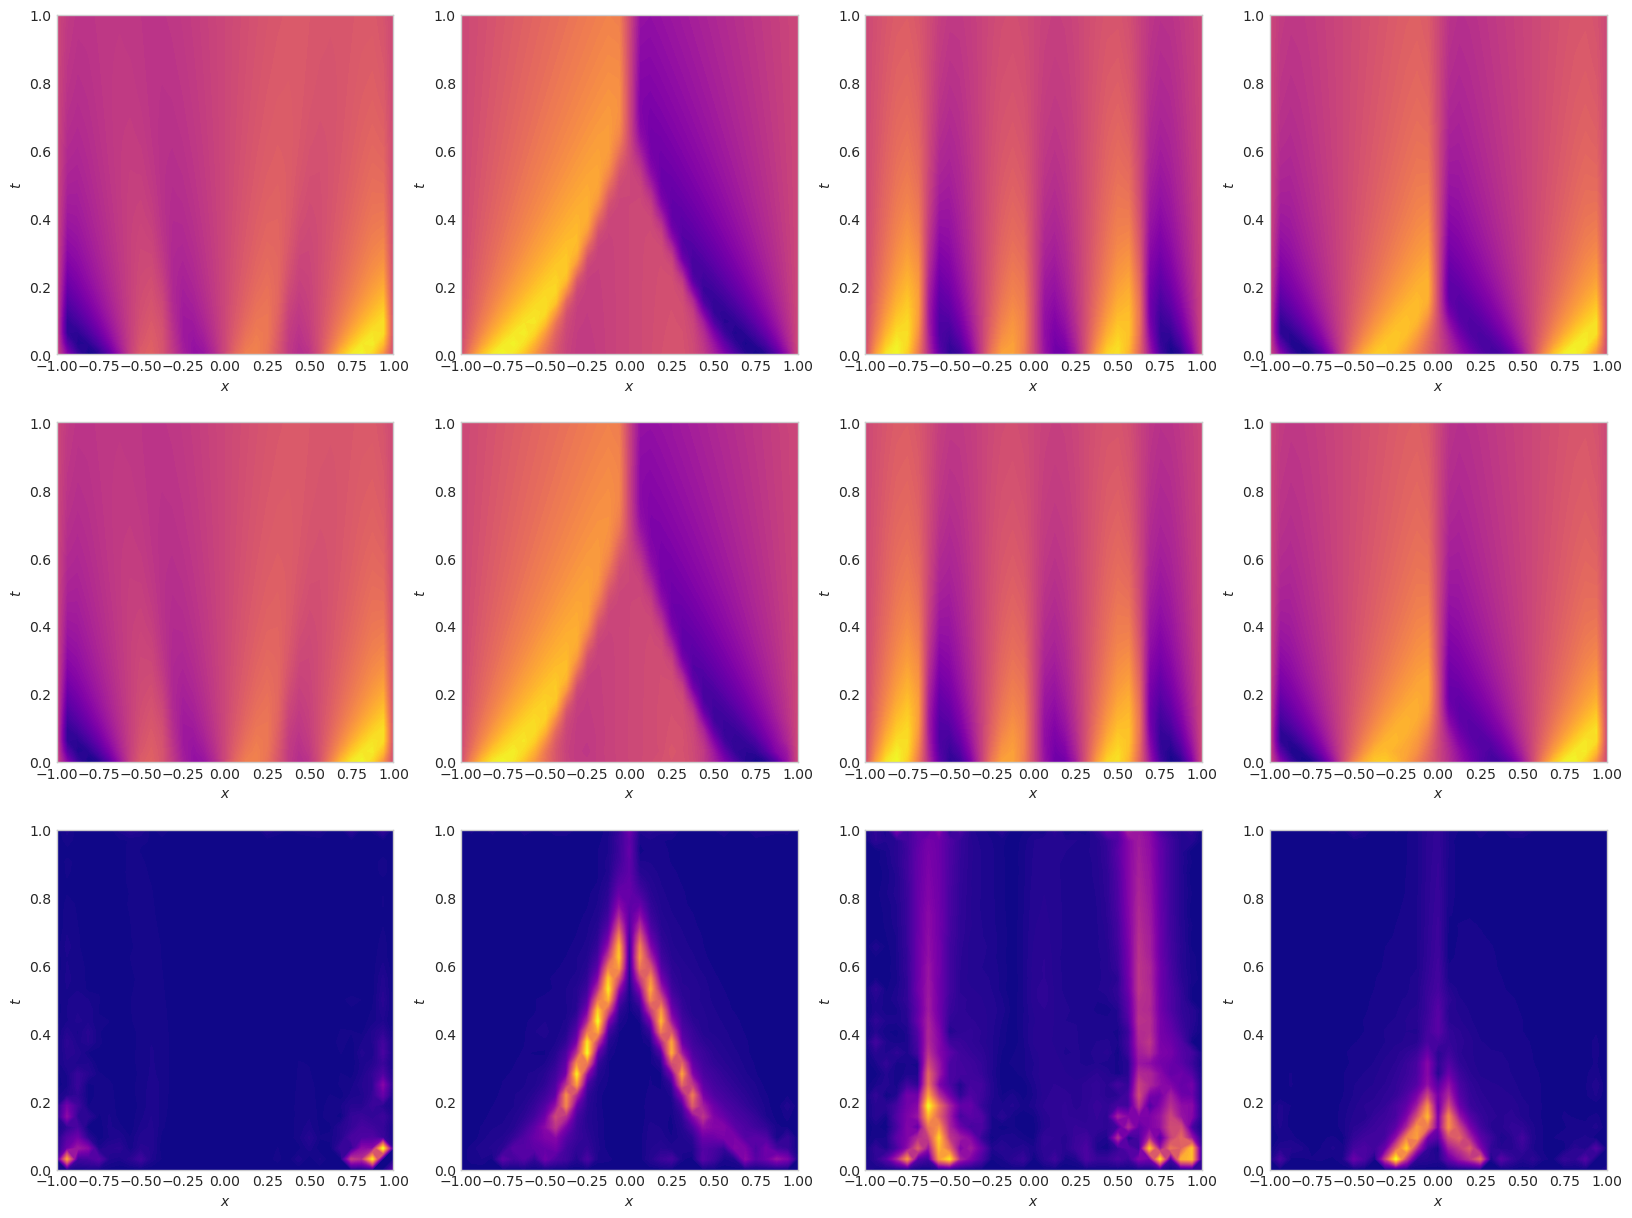

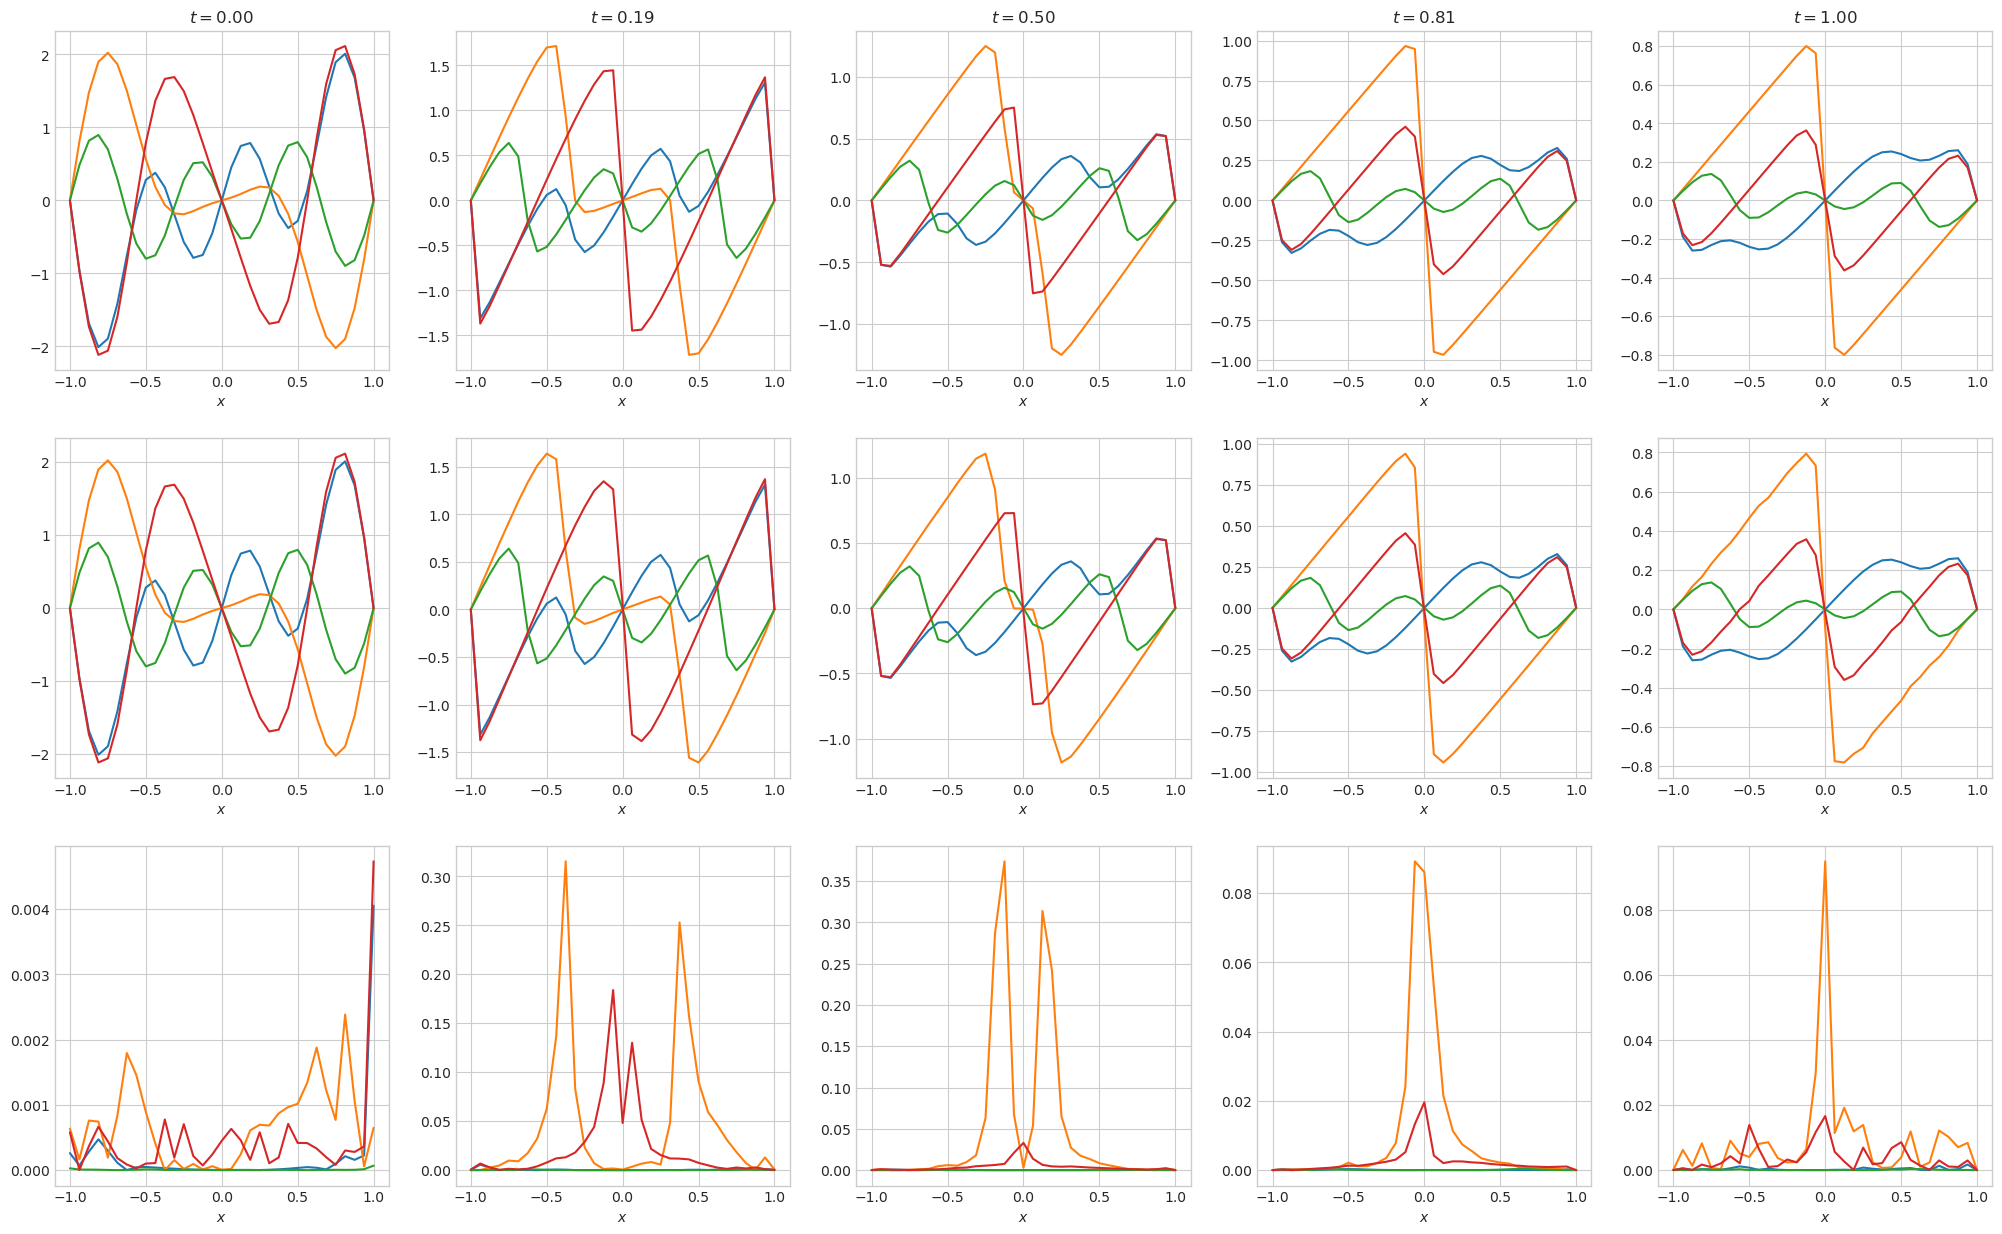

In [11]:
kvec = ki.get_new_left_full_gram_matrix(ticks)
u_ic = u_func(x_ic[:,0])
def get_data(maxiter=10, tag="full", force_gen=False, store_L_chol_hist=True):
    fname = "%s/%s.%s"%(ROOT,"burgers_1d_data",tag)
    _tril_i0,_tril_i1 = torch.tril_indices(ki.ntot,ki.ntot)
    if (not os.path.exists(fname+".npz")) or force_gen:
        data = {
            "vopt": np.empty((R,maxiter+1,ki.length)),
            "losses_opt": np.empty((R,maxiter+1)),
            "vhats": np.empty((R,maxiter+1,nxticks,ntticks)),
            "l2relerrors": np.empty((R,maxiter+1))}
        if store_L_chol_hist:
            data["L_chols"] = np.empty((R,maxiter,int(ki.ntot/2*(1+ki.ntot))))
        print("r from 0 to %d, l2 relative errors\n"%(R)+"~"*100)
        verbosity = max(R//16,1)
        for r in range(R):
            if (r+1)%verbosity==0: print("r = %d: "%(r+1),end='',flush=True)
            def pde_lhs_r(ly_i, ly_bc, ly_ic):
                v_i,v_x_i,v_t_minus_NU_v_xx_i = ly_i
                v_bc = ly_bc[0]
                v_ic = ly_ic[0]
                lhs_i = v_i*v_x_i+v_t_minus_NU_v_xx_i
                lhs_bc = v_bc
                lhs_ic = v_ic
                return lhs_i,lhs_bc,lhs_ic
            def pde_rhs_r(x_i, x_bc, x_ic):
                y_i = torch.zeros(len(x_i),dtype=float)
                y_bc = torch.zeros(len(x_bc),dtype=float)
                y_ic = u_ic[r]
                return y_i,y_bc,y_ic
            y,data_r = ki.pde_opt_gauss_newton(
                pde_lhs = pde_lhs_r,
                pde_rhs = pde_rhs_r,
                maxiter = maxiter,
                store_L_chol_hist = store_L_chol_hist,
                verbose = False)
            data["vopt"][r] = data_r["zhist"].numpy()
            data["losses_opt"][r] = data_r["losses"].numpy()
            data["vhats"][r] = (kvec@ki._solve(data_r["zhist"].T)).T.reshape((-1,nxticks,ntticks)).numpy()
            data["l2relerrors"][r] = (torch.linalg.norm(torch.from_numpy(data["vhats"][r]).reshape((-1,nticks))-vticks[r].flatten(),dim=1)/torch.linalg.norm(vticks[r].flatten())).numpy()
            if store_L_chol_hist:
                data["L_chols"][r] = data_r["L_chol_hist"][:,_tril_i0,_tril_i1].numpy()
            if (r+1)%verbosity==0:
                with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
                    print(data["l2relerrors"][r])        
        np.savez_compressed(fname,**data)
    data = np.load(fname+".npz")
    if store_L_chol_hist:
        L_chols = torch.empty((R,maxiter,ki.ntot,ki.ntot),dtype=torch.float64)
        L_chols[:,:,_tril_i0,_tril_i1] = torch.from_numpy(data["L_chols"])
    else:
        L_chols = None
    return (
        torch.from_numpy(data["vopt"]),
        torch.from_numpy(data["losses_opt"]),
        torch.from_numpy(data["vhats"]),
        torch.from_numpy(data["l2relerrors"]),
        L_chols)
maxiter = 6
vopt,losses_opt,vhats,l2rerrs,L_chols = get_data(maxiter=maxiter,tag="big",force_gen=False,store_L_chol_hist=False)
print("iter avg l2rerrs:",l2rerrs.mean(0).numpy())
best_idxs = losses_opt.argmin(1)
vopt_best = vopt[np.arange(R),best_idxs,:]
if True:
    fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(8,4))
    ax[0].set_title("pseudo-losses")
    ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T,color="k",linewidth=LWTHIN)
    ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T[:,:plt_highlights],linewidth=LW)
    ax[0].set_yscale("log",base=10)
    ax[1].set_title(r"$L_2$ relative errors")
    ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T,color="k",linewidth=LWTHIN)
    ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T[:,:plt_highlights],linewidth=LW)
    ax[1].set_yscale("log",base=10)
    fig.show()
    fig,ax = pyplot.subplots(nrows=3,ncols=plt_highlights,figsize=(5*plt_highlights,5*3))
    for i in range(plt_highlights):
        ax[0,i].contourf(xmesh,tmesh,vticks[i],cmap=cm.plasma,levels=100)
        ax[1,i].contourf(xmesh,tmesh,vhats[i,-1],cmap=cm.plasma,levels=100)
        ax[2,i].contourf(xmesh,tmesh,torch.abs(vticks[i]-vhats[i,-1]),cmap=cm.plasma,levels=100)
        for l in range(3): ax[l,i].set_xlabel(r"$x$"); ax[l,i].set_ylabel(r"$t$")
    fig.show()
    tpltidxs = [0,ntticks//5,ntticks//2,4*ntticks//5,ntticks-1]
    fig,ax = pyplot.subplots(nrows=3,ncols=len(tpltidxs),figsize=(5*len(tpltidxs),5*3))
    for i,tiplt in enumerate(tpltidxs):
        ax[0,i].set_title(r"$t = %.2f$"%tticks[tiplt])
        ax[0,i].plot(xticks,vticks[:plt_highlights,:,tiplt].T)
        ax[1,i].plot(xticks,vhats[:plt_highlights,-1,:,tiplt].T)
        ax[2,i].plot(xticks,torch.abs(vticks[:plt_highlights,:,tiplt]-vhats[:plt_highlights,-1,:,tiplt]).T)
        for l in range(3):
            ax[l,i].set_xlabel(r"$x$")

## Training and Validation Dataloaders

In [12]:
(
 u_ic_train,u_ic_val,
 vticks_train,vticks_val,
 vopt_train,vopt_val,
 vhats_train,vhats_val,
 l2rerrs_train,l2rerrs_val,
 #L_chols_train,L_chols_val
) = qp.train_val_split(R,
                       [
                           u_ic,vticks,vopt,vhats,l2rerrs,#L_chols
                       ],shuffle=False)
print("u_ic_train.shape:",tuple(u_ic_train.shape))
print("vticks_train.shape:",tuple(vticks_train.shape))
print("vopt_train.shape:",tuple(vopt_train.shape))
print("vhats_train.shape:",tuple(vhats_train.shape))
print("l2rerrs_train.shape:",tuple(l2rerrs_train.shape))
#print("L_chols_train.shape:",tuple(L_chols_train.shape))
print()
print("u_ic_val.shape:",tuple(u_ic_val.shape))
print("vticks_val.shape:",tuple(vticks_val.shape))
print("vopt_val.shape:",tuple(vopt_val.shape))
print("vhats_val.shape:",tuple(vhats_val.shape))
print("l2rerrs_val.shape:",tuple(l2rerrs_val.shape))
#print("L_chols_val.shape:",tuple(L_chols_val.shape))

u_ic_train.shape: (7168, 2048)
vticks_train.shape: (7168, 33, 33)
vopt_train.shape: (7168, 7, 8704)
vhats_train.shape: (7168, 7, 33, 33)
l2rerrs_train.shape: (7168, 7)

u_ic_val.shape: (1024, 2048)
vticks_val.shape: (1024, 33, 33)
vopt_val.shape: (1024, 7, 8704)
vhats_val.shape: (1024, 7, 33, 33)
l2rerrs_val.shape: (1024, 7)


## Neural Operator

In [ ]:
relaxations = torch.tensor([1.])
dataset_train = qp.DatasetLowerTriMatOpLearn(vopt_train,L_chols_train,relaxations=relaxations,device=DEVICE,steps="all",fp32=False)
dataset_val = qp.DatasetLowerTriMatOpLearn(vopt_val,L_chols_val,relaxations=relaxations,device=DEVICE,steps="all",fp32=False)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=2**9,collate_fn=tuple,shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=len(dataset_val),collate_fn=tuple,shuffle=False)
print("len(dataset_train):",len(dataset_train))
print("len(dataset_val):",len(dataset_val))
print("len(dataloader_train):",len(dataloader_train))
print("len(dataloader_val):",len(dataloader_val))

### MLP

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

save_dir = ROOT+"/"
name = "NORIS_MLP"
resume = False

mlp = MultilayerPerceptron(
    #mlp_layer_nodes = [2*nxticks+2,500,100,1500,1750,2000,1750,(1+(nxticks+2))*(nxticks+2)//2],
    mlp_layer_nodes = [ki.length,int(ki.ntot/2*(1+ki.ntot)),int(51/2*(1+51))],
    #mlp_layer_nodes = [nxticks,250,500,750,1000,1250,(1+(nxticks+2))*(nxticks+2)//2],
    #mlp_layer_nodes = [2*nxticks+2,250,500,750,1000,1250,(1+(nxticks+2))*(nxticks+2)//2],
    #activation_function = torch.nn.LogSigmoid(),
    activation_function = torch.nn.Tanh(),
    #activation_function = torch.nn.SiLU(),
    #weight_init_scheme = torch.nn.init.kaiming_normal_,
    #weight_init_scheme = torch.nn.init.xavier_normal_,
    batch_norm = False)

mlp = mlp.to(torch.float64)
noris_mlp = NORISLightningMLP(mlp,automatic_optimization=True,fnorm_weight=1.,kl_weight=0.)

assert noris_mlp.ftype==dataset_train.v.dtype
print()
print("number train: %.2e"%len(dataset_train))
print("number val  : %.2e"%len(dataset_val))
print()
print(noris_mlp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 3,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 1.0,
    #gradient_clip_algorithm = "norm",
  )
trainer.fit(
    model = noris_mlp, 
    train_dataloaders = dataloader_train,
    val_dataloaders = dataloader_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

## Operator Leraning Classic

In [32]:
dataset_classic_train = qp.DatasetClassicOpLearn(u_ic_train,vopt_train[:,-1,:],device=DEVICE,fp32=False)
dataset_classic_val = qp.DatasetClassicOpLearn(u_ic_val[:],vopt_val[:,-1,:],device=DEVICE,fp32=False)
dataloader_classic_train = torch.utils.data.DataLoader(dataset_classic_train,batch_size=2**8,collate_fn=tuple,shuffle=True)
dataloader_classic_val = torch.utils.data.DataLoader(dataset_classic_val,batch_size=len(dataset_classic_val),collate_fn=tuple,shuffle=False)
print("len(dataset_classic_train):",len(dataset_classic_train))
print("len(dataset_classic_val):",len(dataset_classic_val))
print("len(dataloader_chonknoris_train):",len(dataloader_classic_train))
print("len(dataloader_chonknoris_val):",len(dataloader_classic_val))

len(dataset_classic_train): 7168
len(dataset_classic_val): 1024
len(dataloader_chonknoris_train): 28
len(dataloader_chonknoris_val): 1


### MLP

In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()

save_dir = ROOT+"/"
name = "CLASSIC_MLP_CHALLENGE"
resume = True

mlp = qp.MultilayerPerceptron(
    mlp_layer_nodes = [dataset_classic_train.u.size(-1),2000,2000,2000,dataset_classic_train.v.size(-1)],
    activation_function = torch.nn.ReLU(),
    batch_norm = False)

mlp = mlp.to(torch.float64)
classic_mlp = qp.ml.lm_oplearn_classic_mlp.LMOpLearnClassicMLP(
    mlp,
    automatic_optimization=True,
    learning_rate=1e-3)

assert classic_mlp.ftype==dataset_classic_train.v.dtype
print(classic_mlp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 500,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 1.0,
    #gradient_clip_algorithm = "norm",
  )
trainer.fit(
    model = classic_mlp, 
    train_dataloaders = dataloader_classic_train,
    val_dataloaders = dataloader_classic_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./CLASSIC_MLP_CHALLENGE/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./CLASSIC_MLP_CHALLENGE/csv/checkpoints exists and is not empty.
Restoring states from the checkpoint path at ././/CLASSIC_MLP_CHALLENGE/csv/checkpoints/epoch=49-step=1400.ckpt


LMOpLearnClassicMLP(
  (mlp): MultilayerPerceptron(
    (mlp_sequential): Sequential(
      (0): Linear(in_features=2048, out_features=2000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2000, out_features=2000, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2000, out_features=2000, bias=True)
      (5): ReLU()
      (6): Linear(in_features=2000, out_features=8704, bias=True)
    )
  )
)



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type                 | Params | Mode 
------------------------------------------------------
0 | mlp  | MultilayerPerceptron | 29.5 M | train
------------------------------------------------------
29.5 M    Trainable params
0         Non-trainable params
29.5 M    Total params
118.075   Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at ././/CLASSIC_MLP_CHALLENGE/csv/checkpoints/epoch=49-step=1400.ckpt


Sanity Checking: |                             | 0/? [00:00<?, ?it/s]

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                    | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


train_mse   val_mse
0     2.584379  1.994216
50    0.817066  0.898032
100   0.497983  0.617292
150   0.431274  0.562873
200   0.485832  0.664350
250   0.330552  0.535969
300   0.335910  0.575836
350   0.325657  0.509388
400   0.318297  0.568906
450   0.272808  0.514396

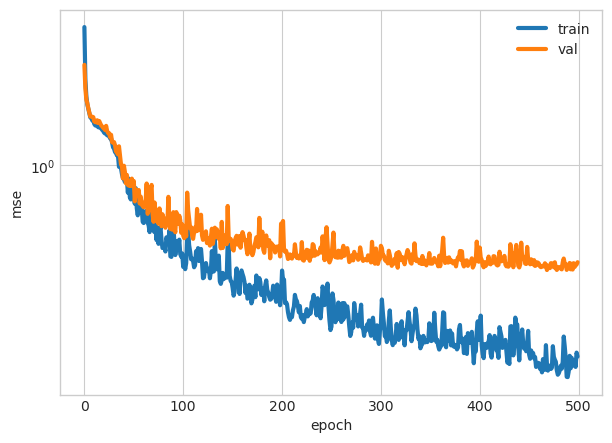

In [36]:
metrics = qp.parse_metrics("%s/%s/csv/metrics.csv"%(save_dir,name))
fig,ax = qp.plot_metrics(metrics)
metrics.iloc[::max(1,len(metrics)//10)]

### GP

In [56]:
save_dir = ROOT+"/"
name = "CLASSIC_GP_CHALLENGE"
resume = False

import gc
gc.collect()
torch.cuda.empty_cache()

gp = qp.IndepVecVGP(
    num_inducing_pts=8,
    num_tasks=dataset_classic_train.v.size(-1),
    dimension=dataset_classic_train.u.size(-1),
    # mean_module = gpytorch.means.LinearMean(
    #     input_size=dataset_classic_train.u.size(-1),
    #     batch_shape=torch.Size([dataset_classic_train.v.size(-1)])),
    covar_module = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.LinearKernel(
            batch_shape=torch.Size([dataset_classic_train.v.size(-1)]),
            ard_num_dims=dataset_classic_train.u.size(-1)),
        batch_shape=torch.Size([dataset_classic_train.v.size(-1)]))
    # covar_module = gpytorch.kernels.ScaleKernel(
    #     gpytorch.kernels.MaternKernel(
    #         nu = 0.5,
    #         batch_shape=torch.Size([dataset_classic_train.v.size(-1)]),
    #         ard_num_dims=dataset_classic_train.u.size(-1)),
    #     batch_shape=torch.Size([dataset_classic_train.v.size(-1)]))
)
num_latents = 100
gp = MultitaskGPModel(
    num_inducing_pts=32,
    num_tasks=dataset_classic_train.v.size(-1),
    dimension=dataset_classic_train.u.size(-1),
    num_latents = num_latents,
    # mean_module = gpytorch.means.LinearMean(
    #     input_size=dataset_classic_train.u.size(-1),
    #     batch_shape=torch.Size([num_latents])),
    # covar_module = gpytorch.kernels.ScaleKernel(
    #     gpytorch.kernels.LinearKernel(
    #         batch_shape=torch.Size([num_latents]),
    #         ard_num_dims=dataset_classic_train.u.size(-1)),
    #     batch_shape=torch.Size([num_latents]))
    # covar_module = gpytorch.kernels.ScaleKernel(
    #     gpytorch.kernels.MaternKernel(
    #         nu = 0.5,
    #         batch_shape=torch.Size([num_latents]),
    #         ard_num_dims=dataset_classic_train.u.size(-1)),
    #     batch_shape=torch.Size([num_latents]))
)
gp = gp.double()

classic_gp = qp.ml.lm_oplearn_classic_gp.LMOpLearnClassicGP(gp, 
                 automatic_optimization = True, 
                 fixed_noise = True,
                 learning_rate = .1,
                 noise_lb = 1e-8)

assert classic_gp.ftype==dataset_classic_train.v.dtype
print(classic_gp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 100,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 1.0,
    #gradient_clip_algorithm = "norm",
  )

trainer.fit(
    model = classic_gp, 
    train_dataloaders = dataloader_classic_train,
    val_dataloaders = dataloader_classic_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type             | Params | Mode 
--------------------------------------------------
0 | gp   | MultitaskGPModel | 7.7 M  | train
1 | mll  | VariationalELBO  | 7.7 M  | train
--------------------------------------------------
7.7 M     Trainable params
1         Non-trainable params
7.7 M     Total params
30.939    Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


LMOpLearnClassicGP(
  (gp): MultitaskGPModel(
    (variational_strategy): LMCVariationalStrategy(
      (base_variational_strategy): VariationalStrategy(
        (_variational_distribution): CholeskyVariationalDistribution()
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RQKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_alpha_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (mll): VariationalELBO(
    (likelihood): MultitaskGaussianLikelihood(
      (raw_noise_constraint): GreaterThan(1.000E-08)
    )
    (model): MultitaskGPModel(
      (variational_strategy): LMCVariationalStrategy(
        (base_variational_strategy): VariationalStrategy(
          (_variational_distribution): CholeskyVariationalDistribution()
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): RQKernel(
          (raw_lengthscale_constrain

Sanity Checking: |                             | 0/? [00:00<?, ?it/s]

Training: |                                    | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


train_loss      val_loss    train_mse      val_mse
0   2.846798e+17  2.330219e+16  6477.871500  2313.949735
2   3.233110e+14  7.612424e+13   252.732492   132.256300
4   1.496129e+12  4.376832e+11    17.437892    10.025872
6   8.332649e+10  7.136719e+10     4.361592     4.043199
8   5.789620e+10  5.578102e+10     3.639164     3.573147
10  5.085186e+10  5.007867e+10     3.410317     3.385030
12  4.738560e+10  4.710291e+10     3.291031     3.282677
14  4.536131e+10  4.531925e+10     3.220497     3.219844
16  4.407596e+10  4.418488e+10     3.174189     3.179305
18  4.323679e+10  4.342867e+10     3.143713     3.152048
20  4.269993e+10  4.295412e+10     3.123548     3.134887
22  4.234445e+10  4.264910e+10     3.111745     3.123864
24  4.264578e+10  4.264786e+10     3.122332     3.123986

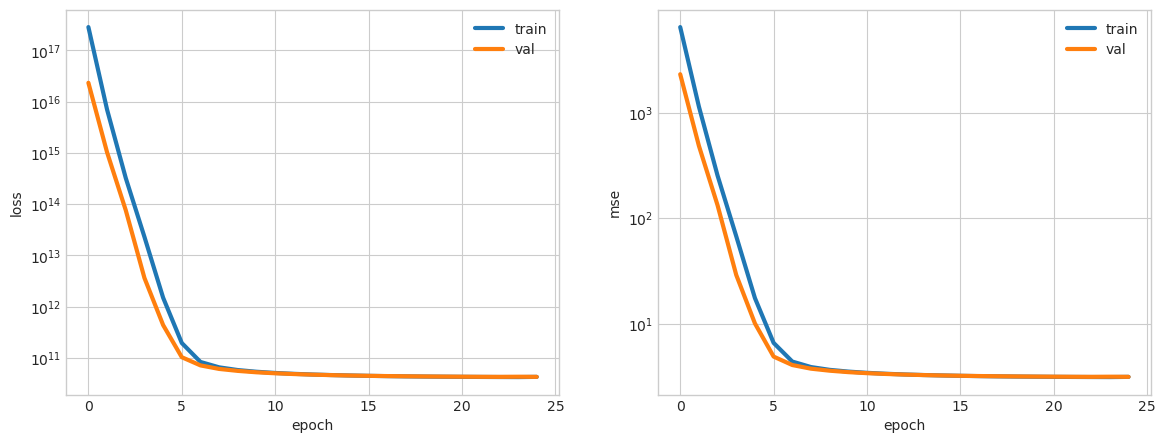

In [50]:
metrics = qp.parse_metrics("%s/%s/csv/metrics.csv"%(save_dir,name))
fig,ax = qp.plot_metrics(metrics)
metrics.iloc[::max(1,len(metrics)//10)]

## Inference

In [37]:
#noris = noris_mlp
#noris = noris_gp
classic = classic_mlp
#classic = classic_gp

In [38]:
class NORISPrecond(qp.kernel_methods.pcg_module.preconditioners._BasePrecond):
    def __init__(self, v):
        self.v = v
    def solve(self, y):
        x = noris.linsolve(y,self.v)
        return x
#noris.eval()
#noris.to("cpu")
#classic.train()
#classic.to(DEVICE)
ridxs = [i for i in range(4)]
numrs = len(ridxs)
maxiter = 8
numpreds = maxiter+1
vhat_ref = [None]*numrs
vhat_enhanced = [None]*numrs
times_ref = [None]*numrs
times_enhanced = [None]*numrs
for i,r in enumerate(ridxs):
    print("ridxs[%d] = %d"%(i,r))
    u_r = u_ic_val[r]
    def pde_lhs_r(ly_i, ly_bc, ly_ic):
        v_i,v_x_i,v_t_minus_NU_v_xx_i = ly_i
        v_bc = ly_bc[0]
        v_ic = ly_ic[0]
        lhs_i = v_i*v_x_i+v_t_minus_NU_v_xx_i
        lhs_bc = v_bc
        lhs_ic = v_ic
        return lhs_i,lhs_bc,lhs_ic
    def pde_rhs_r(x_i, x_bc, x_ic):
        y_i = torch.zeros(len(x_i),dtype=float)
        y_bc = torch.zeros(len(x_bc),dtype=float)
        y_ic = u_r
        return y_i,y_bc,y_ic
    with torch.no_grad():
        t0 = time.perf_counter()
        # u_r_g = u_r.to(DEVICE)[None,:]
        # z0_g = classic.forward(u_r_g)[0]
        # z0 = z0_g.cpu()
        z0 = classic.forward(u_r[None,:]).reshape(-1)
        t_init = time.perf_counter()-t0
    print("  Reference Method")
    y_ref,data_ref = ki.pde_opt_gauss_newton(
        pde_lhs = pde_lhs_r,
        pde_rhs = pde_rhs_r,
        maxiter = maxiter,
        #precond_setter = lambda pde_gm: qp.kernel_methods.IdentityPrecond(),
        #z0 = z0,
        verbose = False)
    vhat_ref[i] = (kvec@ki._solve(data_ref["zhist"].T)).T.reshape((-1,nxticks,ntticks))
    times_ref[i] = data_ref["times"]
    print("  Enhanced Method")
    y_enhanced,data_enhanced = ki.pde_opt_gauss_newton(
        pde_lhs = pde_lhs_r,
        pde_rhs = pde_rhs_r,
        maxiter = maxiter,
        #custom_lin_solver = lambda v,y: noris.linsolve(y,v),
        #precond_setter = lambda pde_gm: NORISPrecond(pde_gm.z),
        z0 = z0,
        verbose = False)
    vhat_enhanced[i] = (kvec@ki._solve(data_enhanced["zhist"].T)).T.reshape((-1,nxticks,ntticks))
    times_enhanced[i] = data_enhanced["times"]+t_init
    print()
vhat_ref = torch.stack(vhat_ref)
times_ref = torch.stack(times_ref)
l2rerrs_ref = torch.linalg.norm((vhat_ref-vticks_val[ridxs,None,:]).reshape((numrs,numpreds,-1)),dim=2)/torch.linalg.norm(vticks_val[ridxs].reshape((numrs,1,-1)),dim=2)
aerrs_ref = torch.abs(vhat_ref[:,-1,:]-vticks_val[ridxs,:])

vhat_enhanced = torch.stack(vhat_enhanced)
times_enhanced = torch.stack(times_enhanced)
l2rerrs_enhanced = torch.linalg.norm(vhat_enhanced.reshape((numrs,numpreds,-1))-vticks_val[ridxs].reshape((numrs,1,-1)),dim=2)/torch.linalg.norm(vticks_val[ridxs].reshape((numrs,1,-1)),dim=2)
aerrs_enhanced = torch.abs(vhat_enhanced[:,-1,:]-vticks_val[ridxs,:])

with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
    print("l2rerrs_enhanced")
    print(l2rerrs_enhanced.numpy())
    print()

ridxs[0] = 0
  Reference Method
  Enhanced Method

ridxs[1] = 1
  Reference Method
  Enhanced Method

ridxs[2] = 2
  Reference Method
  Enhanced Method

ridxs[3] = 3
  Reference Method
  Enhanced Method

l2rerrs_enhanced
[[2.5e-01 2.4e-01 2.4e-01 2.4e-01 2.4e-01 2.4e-01 2.4e-01 2.4e-01 2.4e-01]
 [1.1e-01 1.1e-01 1.2e-01 1.2e-01 1.3e-01 1.3e-01 1.3e-01 1.3e-01 1.3e-01]
 [5.5e-02 3.5e-02 3.3e-02 3.4e-02 3.4e-02 3.5e-02 3.6e-02 3.6e-02 3.7e-02]
 [9.3e-02 3.3e-03 2.6e-04 3.1e-04 3.1e-04 3.1e-04 3.1e-04 3.1e-04 3.1e-04]]



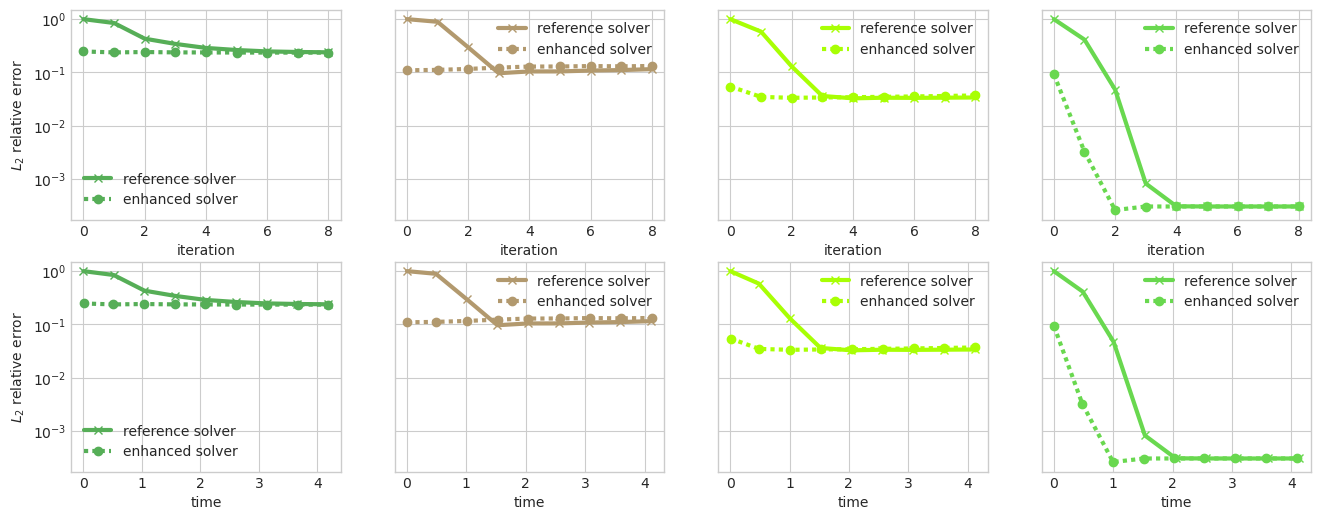

In [40]:
fig,ax = pyplot.subplots(nrows=2,ncols=numrs,figsize=(numrs*4,2*3),sharey=True)
for i in range(numrs):
    times_ref_i = times_ref[i,:]
    l2rerrs_ref_i = l2rerrs_ref[i,:]
    times_enhanced_i = times_enhanced[i,:]
    l2rerrs_enhanced_i = l2rerrs_enhanced[i,:]
    ax[0,i].plot(l2rerrs_ref_i,marker='x',linewidth=LW,color=COLORS[i],label="reference solver")
    ax[0,i].plot(l2rerrs_enhanced_i,marker='o',linewidth=LW,color=COLORS[i],linestyle=(0,(1,1)),label="enhanced solver")
    ax[0,i].legend(frameon=False)
    ax[0,i].set_xlabel("iteration")
    ax[1,i].plot(times_ref_i,l2rerrs_ref_i,marker='x',linewidth=LW,color=COLORS[i],label="reference solver")
    ax[1,i].plot(times_enhanced_i,l2rerrs_enhanced_i,marker='o',linewidth=LW,color=COLORS[i],linestyle=(0,(1,1)),label="enhanced solver")
    ax[1,i].legend(frameon=False)
    ax[1,i].set_xlabel("time")
    #ax[1,i].set_xscale("log",base=10)
ax[1,0].set_yscale("log",base=10)
for j in range(2):
    ax[j,0].set_ylabel(r"$L_2$ relative error");
# ax[1].set_yscale("log",base=10)
# ax[1].set_xscale("log",base=10)